<h1>Analysis of simulations of membrane-protein systems</h1>
<p>
    All the simulations are performed in the grand-canonical ensamble where the membrane is kept at constant lateral pressure (tension) and everything is kept at a temperature of 1.0.
</p><p>
    The membrane is a 30x30 lipid bilayer structure made up of a total of 1800 3-bead lipids (as described in [...]), and proteins are rods with the same mass density and diameter as the lipids and interact with them and other proteins via an interacting tip.
</p><p>
    To analyse the raw data, i.e. generate the data to plot, set the "data_dir" variable to the location of the simulation files and (re)run the two following cells of code...
</p>

In [1]:
%config IPCompleter.greedy=True
#%matplotlib inline
%matplotlib notebook
#%matplotlib widget # for ipympl (needs jupyterlab etc.)

import os, glob
from lammps_multistate_rods.tools.clusters import read_cluster_data
from lammps_multistate_rods.tools.potentials import cos_sq

import numpy as np
from math import sqrt
from scipy.stats import linregress

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
_er
data_dir = '/media/data_ntfs/PhD/simulation stuff/amyloids/data/membrane/cossq_1.0_sol-only_err'

In [2]:
# get all the data into appropriate structures

ads_paths = sorted(glob.glob(os.path.join(data_dir, '*_adsorbed')))
b_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_bottom.msd')))
t_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_top.msd')))
f_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_full.msd')))
data_points = len(ads_paths)
assert len(b_msd_paths) == len(t_msd_paths) == len(f_msd_paths) == data_points

def read_msd_data(filepath):
    msds = []
    with open(filepath,'r') as msd_file:
        msd_file.readline(); msd_file.readline()
        for line in msd_file:
            timestep, msd = line.split(' ')
            try:
                timestep = int(timestep)
            except:
                print "error in:", path, "; t =", timestep
            msds.append(float(msd))
    return np.array(msds)

to_average = 100
mem_wcs = set()
mem_epss = set()
int_epss = set()
all_data = {}
data_struct = ['ts', 'As', 'A_eq', 'Nads', 'Nads_eq',\
               'MSDs_b', 'fit_b', 'MSDs_t', 'fit_t', 'MSDs_f', 'fit_f']
for i in range(data_points):
    params = os.path.basename(ads_paths[i]).split('_')[0]
    key = (mem_wc, mem_eps, int_eps) = tuple(map(float, params.split('-')))
    mem_wcs.add(mem_wc)
    mem_epss.add(mem_eps)
    int_epss.add(int_eps)
    data = []
    all_data[key] = data
    
    temp = read_cluster_data(ads_paths[i])
    data.append(np.array(temp[0])) #timesteps
    data.append(np.array(map(lambda (lx, ly, lz): lx*ly, temp[1]))) #membrane areas
    data.append(np.average(data[-1][-to_average:])) #"equilibrium" membrane area
    data.append(np.array([len(ads_IDs) for ads_IDs in temp[2]])) #numbers of ads proteins
    data.append(np.average(data[-1][-to_average:])) #"equilibrium" number of ads proteins
    
    try:
        cutoff = int(0.2*len(data[0]))
        data.append(read_msd_data(b_msd_paths[i]))
        data.append(linregress(data[0][cutoff:], data[-1][cutoff:])) # D, b, _, _, sigma
        data.append(read_msd_data(t_msd_paths[i]))
        data.append(linregress(data[0][cutoff:], data[-1][cutoff:]))
        data.append(read_msd_data(f_msd_paths[i]))
        data.append(linregress(data[0][cutoff:], data[-1][cutoff:]))
    except:
        print "error with:", key
    #TODO scale Ds with 1/dt

mem_wcs = sorted(mem_wcs)
mem_epss = sorted(mem_epss)
int_epss = sorted(int_epss)

<h2>Interactions and interaction parameters</h2>
<p>
    There are 3 interactions at play in the simulations:
    <ol>
        <li><b>intra-membrane</b> - this is consisted of inter-lipid (WCA and/or cosine-squared) and intra-lipid (FENE bond and harmonic angle bond) interactions that are described in detail in [...]; the relevant parameters are:
            <ul>
                <li>$\sigma$ - the bead diameter / general length-scale (fixed at 1.0),</li>
                <li>$\epsilon_{mem}$ - the interaction strength (variable), and</li>
                <li>$w_c$ - the cosine-squared interaction width (variable)</li>
            </ul>
        </li>
        <br>
        <li><b>inter-protein</b> - this is defined in the <tt>lammps_multistate_rods</tt> ".cfg" configuration file (3.25 cosine-squared tip-tip interaction with width = 0.5$\sigma$ superimposed on a 5.0 WCA soft volume-exclusion interaction)</li>
        <br>
        <li><b>protein-lipid</b> - this interaction is consisted of 3 bead-bead interactions between the interacting tip of a protein and all three beads (head-tail-tail) of a lipid. All the interactions are a WCA+cosine-squared interaction with width = 0.5$\sigma$ and the parameters are the strength $\epsilon_{int}$ and the "signature" (k1, k2, k3) where each number is a strength factor (to multiply $\epsilon_{int}$) for the interaction between the protein tip and the corresponding lipid bead. The "signature" is fixed to (1.0, 0.5, 0.25) while $\epsilon_{int}$ is variable. The resulting interaction is shown after running the following code cell...</li>
    </ol>
</p>

<IPython.core.display.Javascript object>


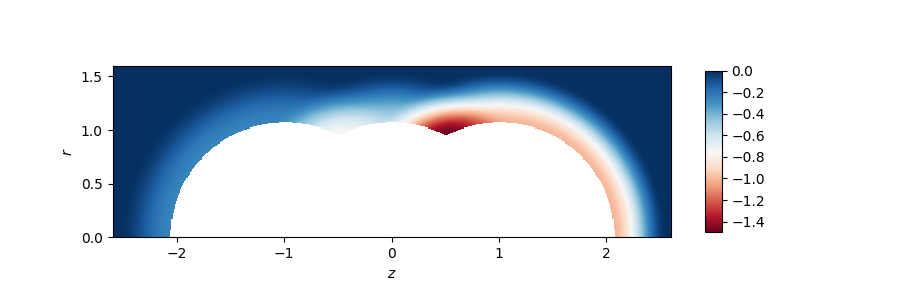

In [12]:
sigma = 1.0
dx = 0.01
rmin = 0.0; rmax = 1.6*sigma
r_points = int((rmax-rmin)/dx) + 1
rs = np.linspace(rmin, rmax, r_points)
zmin = -2.6*sigma; zmax = 2.6*sigma
z_points = int((zmax-zmin)/dx) + 1
zs = np.linspace(zmin, zmax, z_points)
bead_zs = (sigma, 0.0, -sigma)

eps = 1.0
bead_ks = (1.0, 0.5, 0.25)
lj_factor = 2**(1./6)
contact = 0.5*sigma*(1 + lj_factor)
cutoff = contact + 0.5*sigma

vals = np.zeros(r_points*z_points)
for (bz, bk) in zip(bead_zs, bead_ks):
    vals += np.array([cos_sq(sqrt((z-bz)**2 + r**2), contact, cutoff, eps*bk, wca=True)
                     for r in rs for z in zs])
vals = vals.reshape(r_points, z_points)
vals_min = np.min(vals)
vals_max = np.max(vals)

fig = plt.figure(r'Protein-lipid interaction', figsize=(9, 3))
ax_2D = plt.axes()
img_cmap = plt.get_cmap("RdBu")
img = ax_2D.imshow(vals, extent=[zmin, zmax, rmin, rmax], vmin=vals_min, vmax=0.0,
                    origin="lower", interpolation='bilinear', cmap=img_cmap)
fig.colorbar(img, ax=ax_2D, shrink = 0.7, aspect = 10)
ax_2D.set_xlabel(r'$z$')
ax_2D.set_ylabel(r'$r$')
ax_2D.axis([zmin, zmax, rmin, rmax])
plt.show()

<h2>Single simulation timeseries data</h2>
<p>
The code below draws 3 figures with timeseries graphs for a set of parameters identifying a single simulation:
<ol>
    <li>The number of proteins in contact with the membrane</li>
    <li>The mean-squared-displacement (MSD) of the membrane lipids (by layers), along with linear fits to points from 0.2 $t_{max}$ to $t_{max}$</li>
    <li>The area of the membrane</li>
</ol>
The 3 parameters identifying a simulation are:
<ol>
    <li>$w_c$ - The width of the lipid-lipid (cosine/squared) interaction</li>
    <li>$\epsilon_{mem}$ - The lipid-lipid interaction strength</li>
    <li>$\epsilon_{int}$ - The lipid-protein interaction strength</li>
</ol>
and they are given at the begining of the cell (change them and re-run the cell to analyse a particular simulation).
</p>

Max timestep = 10000000, No. points = 1001


<IPython.core.display.Javascript object>


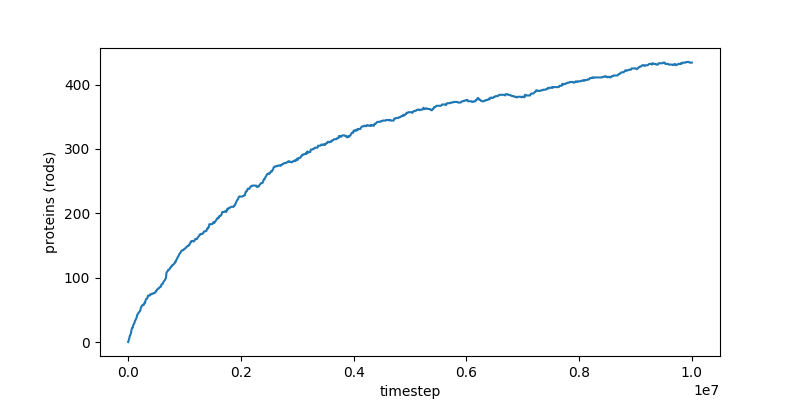

<IPython.core.display.Javascript object>


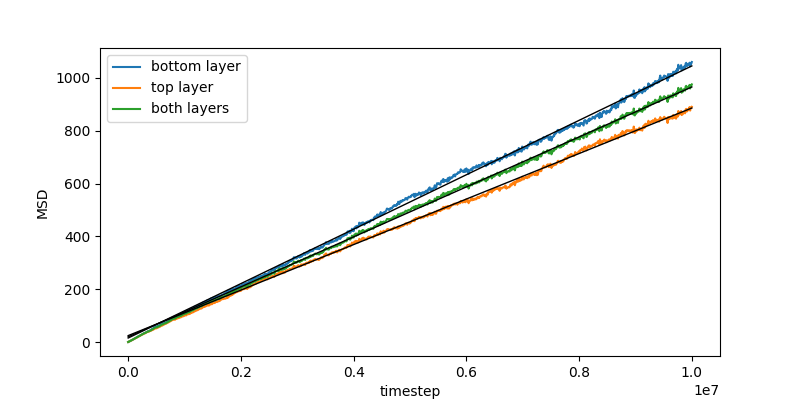

<IPython.core.display.Javascript object>


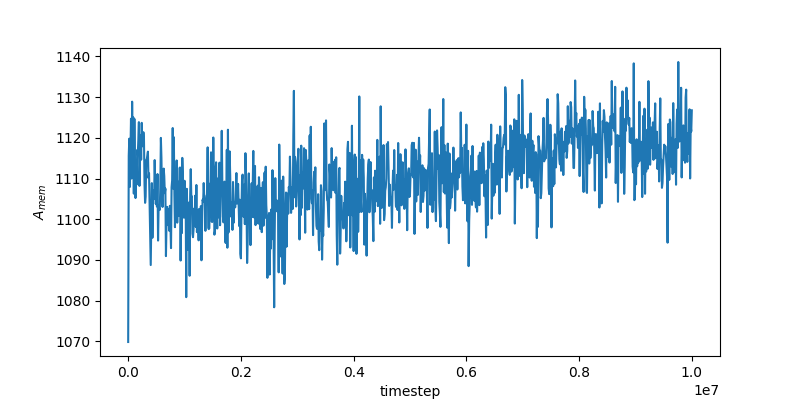

In [13]:
# params to set...
mem_wc = 1.4
mem_eps = 1.11
int_eps = 3.0

try:
    data = all_data[(mem_wc, mem_eps, int_eps)]
except KeyError:
    print "ERROR: No simulation with those parameters!"
    assert False
print "Max timestep = {}, No. points = {}".format(data[0][-1], len(data[0]))

fig = plt.figure(r'Protein adsorption ({:.2f}, {:.2f}, {:.2f})'.format(mem_wc, mem_eps, int_eps), figsize=(8,4))
plt.plot(data[0], data[3])
plt.gca().set_xlabel(r'timestep')
plt.gca().set_ylabel(r'proteins (rods)')

fig = plt.figure(r'MSD of lipids ({:.2f}, {:.2f}, {:.2f})'.format(mem_wc, mem_eps, int_eps), figsize=(8,4))
plt.plot(data[0], data[5], label='bottom layer')
plt.plot(data[0], data[7], label='top layer')
plt.plot(data[0], data[9], label='both layers')
plt.plot(data[0], data[6][1] + data[0]*data[6][0], 'k-', lw=1.0) #TODO err bars
plt.plot(data[0], data[8][1] + data[0]*data[8][0], 'k-', lw=1.0)
plt.plot(data[0], data[10][1] + data[0]*data[10][0], 'k-', lw=1.0)
plt.legend(loc='upper left')
plt.gca().set_xlabel(r'timestep')
plt.gca().set_ylabel(r'MSD')

fig = plt.figure(r'Membrane area ({:.2f}, {:.2f}, {:.2f})'.format(mem_wc, mem_eps, int_eps), figsize=(8,4))
plt.plot(data[0], data[1])
plt.gca().set_xlabel(r'timestep')
plt.gca().set_ylabel(r'$A_{mem}$')

fig.show()

<p>
    The number of adsorbed particles equilibriates for most parameters by at least the last 10% of the simulation, so the average over the last 100 timesteps is taken as the final value. It can also be seen that for some parameters ($\epsilon_{int} \gtrapprox 2.75$) this is not the case and longer simulations should be run, but it seems this is good enough...
</p><p>
    The MSD of the lipids seems to equilibriate much faster so the linear fit to that data is done on all but the first 20% of timesteps. The slope equals the diffusion coefficient and it changes in the initial 20% of the simulation (especially in simulations with a lot of adsorption) because it is affected by the adsorbed proteins which bind to lipids and so reduce their diffusion. This is especially seen with high protein-lipid interactions and on more solid membranes (higher $\epsilon_{mem}$ and/or $w_c$).
</p><p>
    The area of the membrane also equilibriates much faster than adsorption and the average over the last 100 timesteps is a good representative for a final, equilibrated value.
</p>

<h2>Data for simulations at constant $w_c$</h2>
<p>
The code below draws 5 figures with graphs at constant $w_c$ and varying $\epsilon_{mem}$ and $\epsilon_{int}$:
<ol>
    <li>The "equilibrium" (average over the last 100 values) number of proteins in contact with the membrane </li>
    <li>The equilibrium "area" of the membrane (simulation box)</li>
    <li>The "equlibrium" number of adsorbed proteins per unit area of membrane (simulation box)</li>
    <li>The "equilibrium" diffusion coefficient (slope of the MSD data) of the top membrane layer</li>
    <li>The relative difference in the diffusion coefficient between the top and bottom layers</li>
</ol>
The $w_c$ parameter is given at the begining of the cell (change it and re-run the cell to analyse for that value)...
</p>

<IPython.core.display.Javascript object>


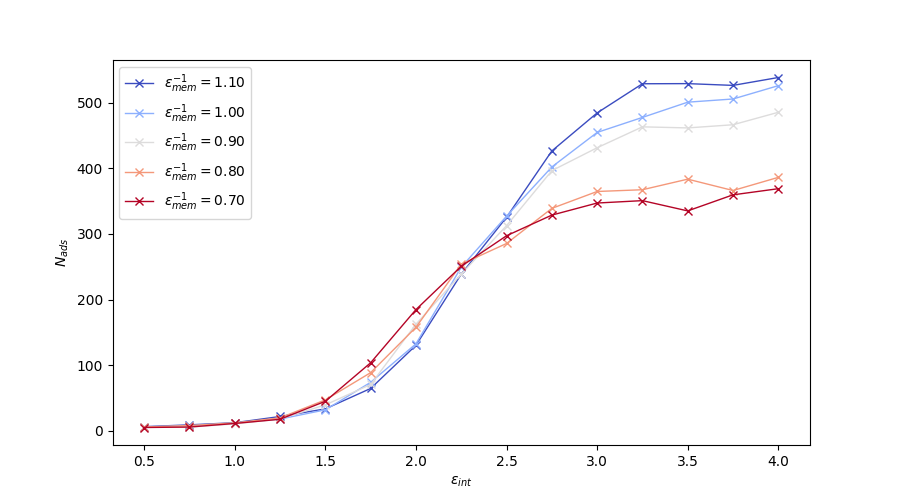

<IPython.core.display.Javascript object>


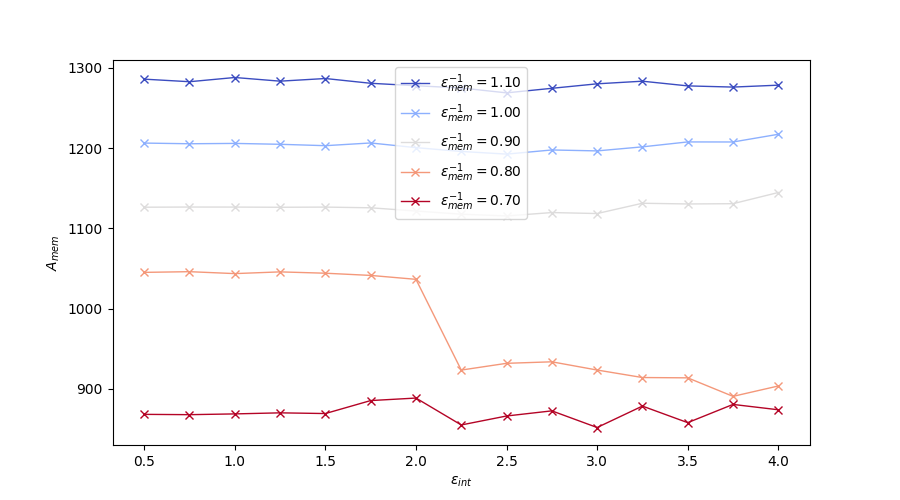

<IPython.core.display.Javascript object>


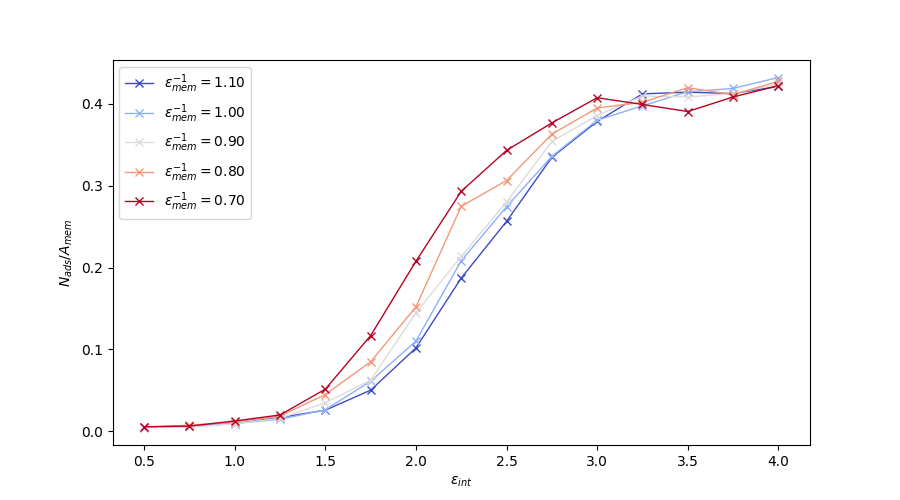

<IPython.core.display.Javascript object>


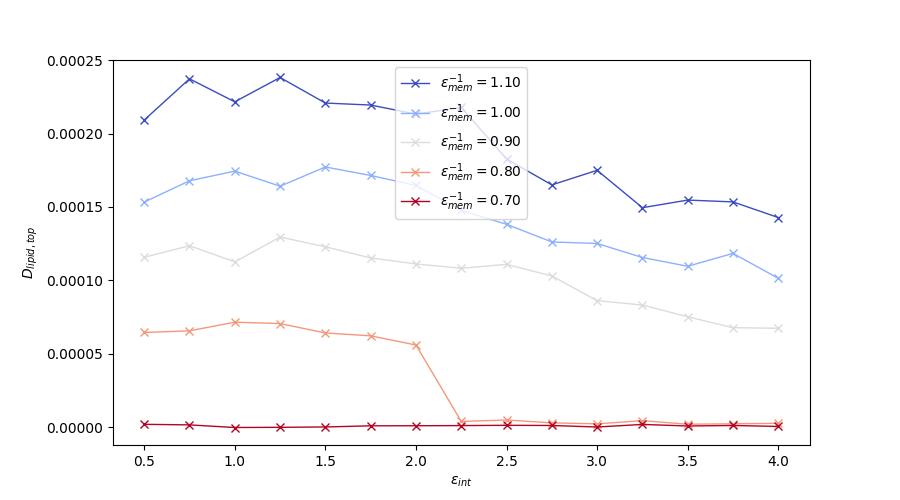

<IPython.core.display.Javascript object>


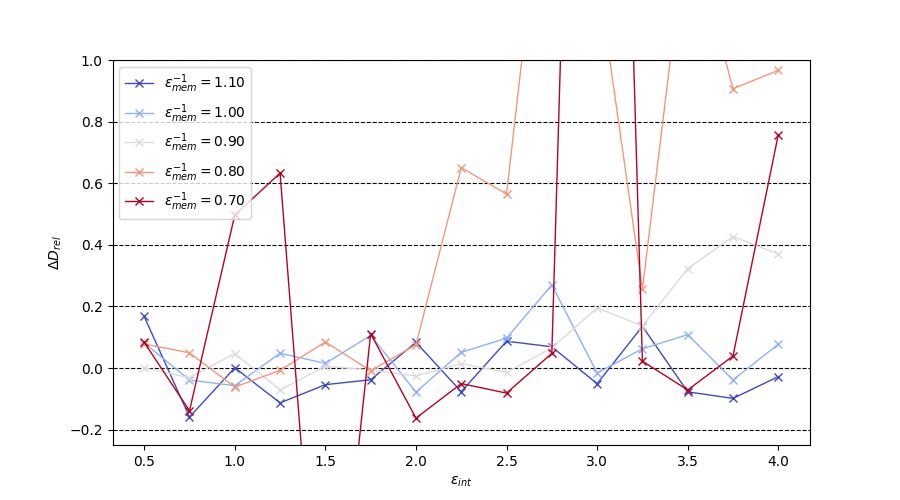

In [14]:
# draw membrane adsorption and diffusion coeffs at a given w_c
wc = 1.4

# 3D interactive plot (only if full grid)
#xs = 1./np.array(mem_epss)
#ys = np.array(int_epss)
#x_dim = len(xs)
#y_dim = len(ys)
#X, Y = np.meshgrid(xs, ys)
#data = [all_data[(wc, mem_eps, int_eps)][4] for int_eps in int_epss for mem_eps in mem_epss]
#Z = np.reshape(data, (y_dim, x_dim))
#fig = plt.figure(r'Membrane adsorption of proteins @ w_c = {:.2f}'.format(wc), figsize=(9,5))
#ax = plt.axes(projection='3d')
#surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#plt.colorbar(surf, shrink=0.5, aspect=10)
#ax.scatter3D(X.ravel(), Y.ravel(), data, s=4, c='k') #as a check of the surf plot
#ax.set_xlabel(r'$\epsilon_{mem}^{-1}$')
#ax.set_ylabel(r'$\epsilon_{int}$')
#ax.set_zlabel(r'$N_{ads}$')

# membrane adsorption...
ads_data = []
for mem_eps in mem_epss:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps, all_data[(wc, mem_eps, int_eps)][4]))
        except KeyError:
            pass
    ads_data.append(temp)

fig = plt.figure(r'Membrane adsorption of proteins @ w_c = {:.2f}'.format(wc), figsize=(9,5))
ax = plt.axes()
N = len(mem_epss)
for i in range(N):
    xs, ys = zip(*ads_data[i])
    ax.plot(xs, ys, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$\epsilon_{mem}^{-1} = %.2f $' % (1/mem_epss[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$N_{ads}$')
ax.legend(loc='upper left')

# membrane size (area) ...
area_data = []
for mem_eps in mem_epss:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps, all_data[(wc, mem_eps, int_eps)][2]))
        except KeyError:
            pass
    area_data.append(temp)

fig = plt.figure('Membrane area @ w_c = {:.2f}'.format(wc), figsize=(9,5))
ax = plt.axes()
for i in range(N):
    xs, ys = zip(*area_data[i])
    ax.plot(xs, ys, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$\epsilon_{mem}^{-1} = %.2f $' % (1/mem_epss[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$A_{mem}$')
ax.legend(loc='upper center')

# adsorption per area ...
fig = plt.figure('Membrane adsorption per area @ w_c = {:.2f}'.format(wc), figsize=(9,5))
ax = plt.axes()
for i in range(N):
    xs, adss = zip(*ads_data[i])
    xs, areas = zip(*area_data[i])
    ax.plot(xs, np.array(adss)/np.array(areas), 'x-',
            lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$\epsilon_{mem}^{-1} = %.2f $' % (1/mem_epss[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$N_{ads} / A_{mem}$')
ax.legend(loc='upper left')

# lipid diffusion...
diff_data = []
for mem_eps in mem_epss:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps,
                         all_data[(wc, mem_eps, int_eps)][6][0],
                         all_data[(wc, mem_eps, int_eps)][8][0],
                         all_data[(wc, mem_eps, int_eps)][10][0]))
        except KeyError:
            pass
    diff_data.append(temp)

fig = plt.figure('Top layer lipid diffusion coefficients @ w_c = {:.2f}'.format(wc), figsize=(9,5))
ax = plt.axes()
fig = plt.figure('Relative difference in diffusion coefficients @ w_c = {:.2f}'.format(wc), figsize=(9,5))
ax2 = plt.axes()
for i in range(N):
    xs, ys_bottom, ys_top, ys_full = map(np.array, zip(*diff_data[i]))
    ax.plot(xs, ys_top, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)),
            label=r'$\epsilon_{mem}^{-1} = %.2f $' % (1/mem_epss[i]))
    ax2.plot(xs, (ys_bottom-ys_top)/ys_top, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), 
             label=r'$\epsilon_{mem}^{-1} = %.2f $' % (1/mem_epss[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax2.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$D_{lipid,top}$')
ax2.set_ylabel(r'${\Delta}D_{rel}$')
ax2.set_ylim([-0.25,1])
ax.legend(loc='upper center')
ax2.legend(loc='upper left')
ax2.grid(axis='y', c='k', linestyle='--')

fig.show()

<p>
    The number of adsorbed proteins seems to have a transition at around $\epsilon_{int} = 2.25$ for all membrane strengths, and the membrane (simulation box) area seems to be fairly constant over all interaction strengths for all membrane strengths, EXCEPT for $\epsilon_{mem}^{-1} = 0.8$ which has a big reduction in area at around the transition interaction strength, which means that protein-lipid interaction can lead to the solidification/crystalisation of the membrane (a liquid-solid transition), if it's strong enough (correct interpretation? interesting?).
</p><p>
    The number of adsorbed proteins per unit area (i.e. the coverage of the membrane) seems to be the relevant quantity as for it the curves for different membrane strengths align and the (phase) transition from low to high adsorption is most easily seen, and corresponds roughly to $\epsilon_{int} = 2.25$ for this model. The saturation of the membrane with proteins seems to be at around 40% coverage, i.e. 40% of membrane surface is covered by proteins.
</p><p>
    The diffusion coefficient seems to drop slightly with increasing interaction strength, which is expected as stronger interacting proteins bind lipids more strongly and restrict their movement more. Of course, it is almost zero for a solid membrane, which is another clear signature of a liquid-solid transition triggered by protein-lipid interaction for the membrane with $\epsilon_{mem}^{-1} = 0.8$.
</p><p>
    Although one would expect the diffusion of the top layer lipids to be smaller than that of the bottom layer ones (because most proteins are bound to the top layer and this binding reduces the diffusion), the relative difference seems to be negligible ($\lt 0.2$ and of changing sign) for all membrane strengths except possibly for $\epsilon_{mem}^{-1} = 0.9$ at higher interaction strengths (the reason for some high values for $\epsilon_{mem}^{-1} = 0.7$ and $\epsilon_{mem}^{-1} = 0.8$ is the vanishingly small absolute value making the relative difference prone to big uncertainties which these big values are undoubtedly the consequence of).
    This is probably explainable by lipid-lipid interactions between layers and proteins entering the membrane and binding to lower layer lipids as well (which is should be less so for stiffer membranes resulting in the $\epsilon_{mem}^{-1} = 0.9$ case).
</p>

<h2>Data for simulations at constant $\epsilon_{mem}$</h2>
<p>
The code below draws 5 figures with graphs at constant $\epsilon_{mem}$ and varying $w_c$ and $\epsilon_{int}$:
<ol>
    <li>The "equilibrium" (average over the last 100 values) number of proteins in contact with the membrane </li>
    <li>The equilibrium "area" of the membrane (simulation box)</li>
    <li>The "equlibrium" number of adsorbed proteins per unit area of membrane (simulation box)</li>
    <li>The "equilibrium" diffusion coefficient (slope of the MSD data) of the top membrane layer</li>
    <li>The relative difference in the diffusion coefficient between the top and bottom layers</li>
</ol>
The $\epsilon_{mem}$ parameter is given at the begining of the cell (change it and re-run the cell to analyse for that value)...
</p>

<IPython.core.display.Javascript object>


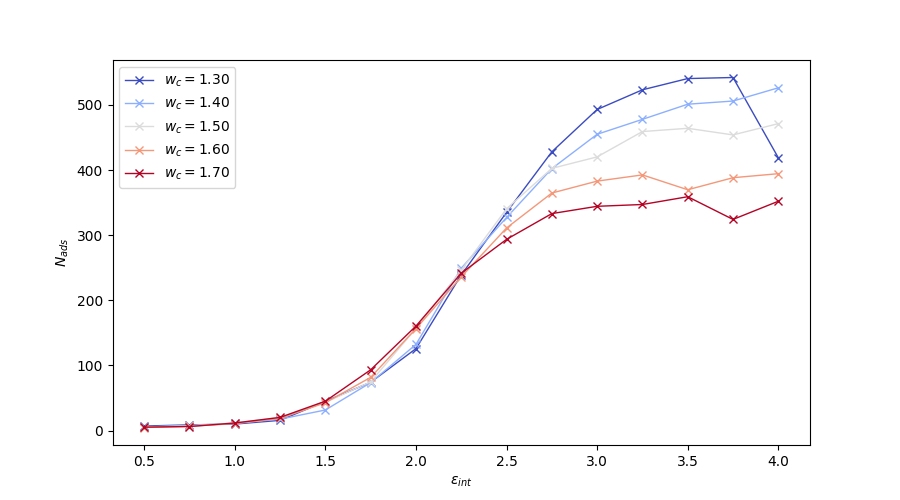

<IPython.core.display.Javascript object>


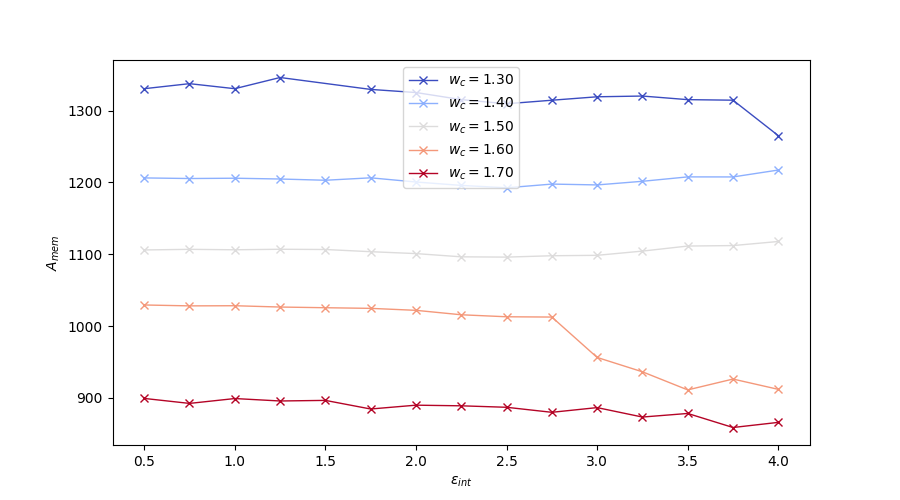

<IPython.core.display.Javascript object>


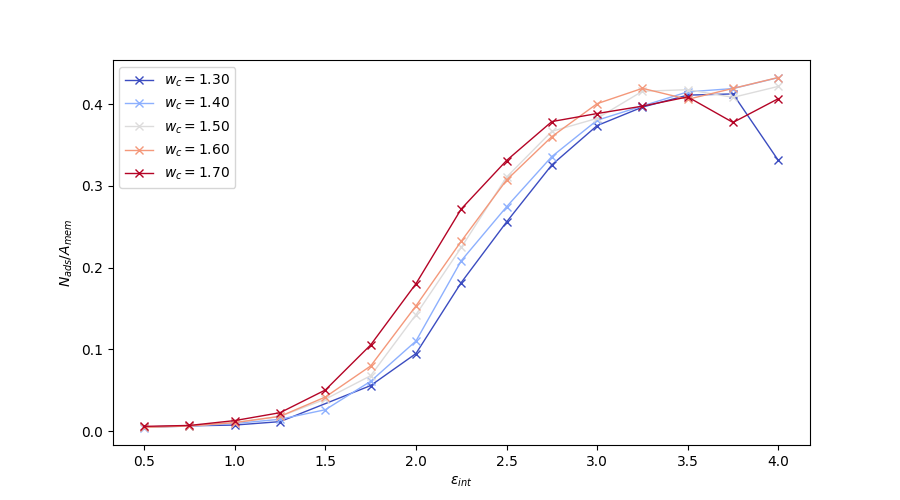

<IPython.core.display.Javascript object>


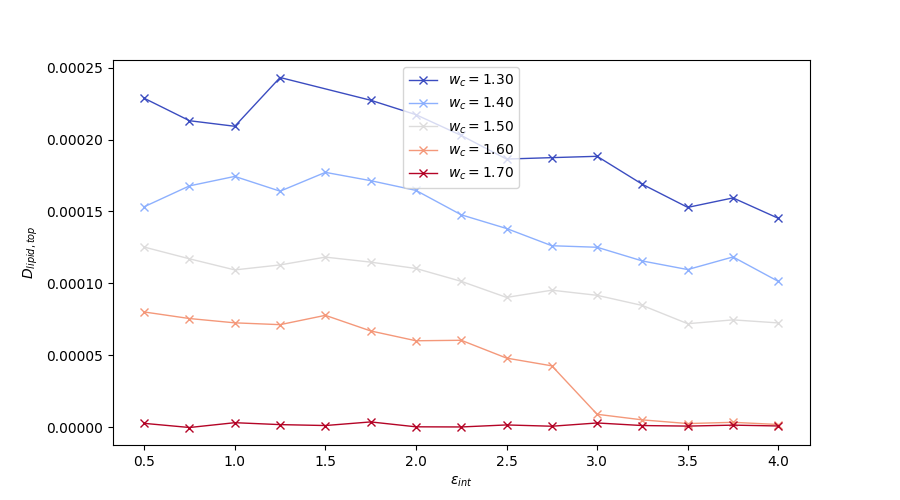

<IPython.core.display.Javascript object>


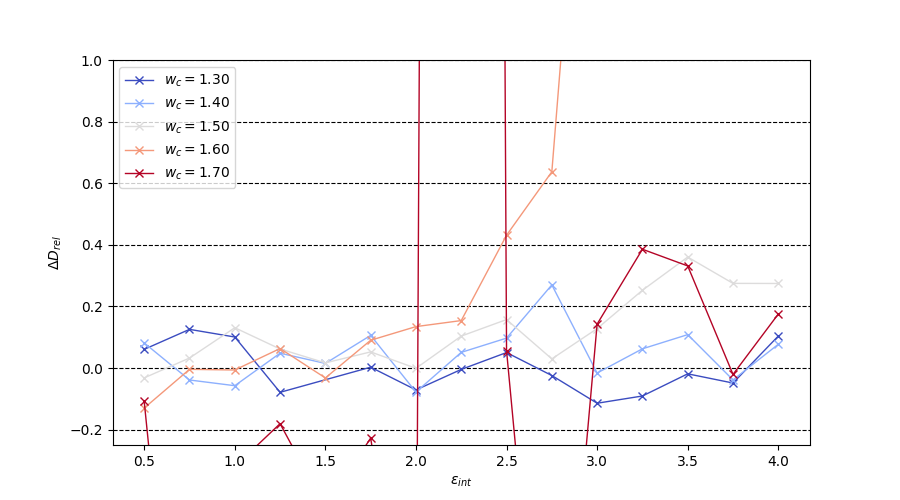

In [15]:
# draw membrane adsorption and diffusion coeffs at a given mem_eps
mem_eps = 1.0

# membrane adsorption...
ads_data = []
for wc in mem_wcs:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps, all_data[(wc, mem_eps, int_eps)][4]))
        except KeyError:
            pass
    ads_data.append(temp)

fig = plt.figure(r'Membrane adsorption of proteins @ mem_eps = {:.2f}'.format(mem_eps), figsize=(9,5))
ax = plt.axes()
N = len(mem_epss)
for i in range(N):
    xs, ys = zip(*ads_data[i])
    ax.plot(xs, ys, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$w_c = %.2f $' % (mem_wcs[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$N_{ads}$')
ax.legend(loc='upper left')

# membrane size (area) ...
area_data = []
for wc in mem_wcs:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps, all_data[(wc, mem_eps, int_eps)][2]))
        except KeyError:
            pass
    area_data.append(temp)

fig = plt.figure('Membrane area @ mem_eps = {:.2f}'.format(mem_eps), figsize=(9,5))
ax = plt.axes()
for i in range(N):
    xs, ys = zip(*area_data[i])
    ax.plot(xs, ys, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$w_c = %.2f $' % (mem_wcs[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$A_{mem}$')
ax.legend(loc='upper center')

# adsorption per area ...
fig = plt.figure('Membrane adsorption per area @ mem_eps = {:.2f}'.format(mem_eps), figsize=(9,5))
ax = plt.axes()
for i in range(N):
    xs, adss = zip(*ads_data[i])
    xs, areas = zip(*area_data[i])
    ax.plot(xs, np.array(adss)/np.array(areas), 'x-',
            lw=1.0, c=cm.coolwarm(1.*i/(N-1)), label=r'$w_c = %.2f $' % (mem_wcs[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$N_{ads} / A_{mem}$')
ax.legend(loc='upper left')

# lipid diffusion...
diff_data = []
for wc in mem_wcs:
    temp = []
    for int_eps in int_epss:
        try:
            temp.append((int_eps,
                         all_data[(wc, mem_eps, int_eps)][6][0],
                         all_data[(wc, mem_eps, int_eps)][8][0],
                         all_data[(wc, mem_eps, int_eps)][10][0]))
        except KeyError:
            pass
    diff_data.append(temp)

fig = plt.figure('Top layer lipid diffusion coefficients @ mem_eps = {:.2f}'.format(mem_eps), figsize=(9,5))
ax = plt.axes()
fig = plt.figure('Relative difference in diffusion coefficients @ mem_eps = {:.2f}'.format(mem_eps), figsize=(9,5))
ax2 = plt.axes()
for i in range(N):
    xs, ys_bottom, ys_top, ys_full = map(np.array, zip(*diff_data[i]))
    ax.plot(xs, ys_top, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)),
            label=r'$w_c = %.2f $' % (mem_wcs[i]))
    ax2.plot(xs, (ys_bottom-ys_top)/ys_top, 'x-', lw=1.0, c=cm.coolwarm(1.*i/(N-1)), 
             label=r'$w_c = %.2f $' % (mem_wcs[i]))
ax.set_xlabel(r'$\epsilon_{int}$')
ax2.set_xlabel(r'$\epsilon_{int}$')
ax.set_ylabel(r'$D_{lipid,top}$')
ax2.set_ylabel(r'${\Delta}D_{rel}$')
ax2.set_ylim([-0.25,1])
ax.legend(loc='upper center')
ax2.legend(loc='upper left')
ax2.grid(axis='y', color='k', linestyle='--')

fig.show()

<p>
    All the conclusions for simulations at constant $w_c$ seem to hold exactly the same for simulations at constant $\epsilon_{mem}$, where membranes with higher $w_c$ while holding $\epsilon_{mem}$ fixed correspond to those with higher $\epsilon_{mem}$ while holding $w_c$ fixed. This makes sense since higher values of either of those parameters translate to a stiffer, more solid membrane (as can be seen in the pahse diagram of ...).
</p><p>
    One thing that can be noticed as a difference is that the protein-lipid-interaction-induced liquid-solid transition of the membrane happens less abruptly and at higher interaction strengths.
</p>